# ViT attempt 1

The overall flow for a Vision Transformer is as follows. You take an image as input and pass it through the following:
1. Image patching
2. Add positional embeddings to each image patch
3. Normalisation
4. Multi-head attention
5. Feedforward/ MLP
6. Normalisation
7. Residual connections (arrows in the diagram)

![ViT diagram](/Users/hannahjayneknight/Desktop/personal/cv_further_learning/ViT/ViT.png "ViT diagram")

### Importing

In [14]:
import torch
import torch.nn as nn
import cv2 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.datasets import OxfordIIITPet
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image


### Loading sample image and dataset

In [15]:
img_src = '/Users/hannahjayneknight/Desktop/personal/cv_further_learning/hetty.jpg'
image = cv2.imread(img_src)
image = cv2.resize(image, (224, 224))

to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target
    

dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))

0.1%

100.0%


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


3.8%

100.0%


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


### 1. Image patching
Source: https://mrinath.medium.com/vit-part-1-patchify-images-using-pytorch-unfold-716cd4fd4ef6

#### Viewing the patching

In [10]:
class Patchify(nn.Module):
    def __init__(self, patch_size=56):
        super().__init__()
        self.p = patch_size
        self.unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x -> B c h w
        bs, c, h, w = x.shape
        
        x = self.unfold(x)
        # x -> B (c*p*p) L
        
        # Reshaping into the shape we want
        a = x.view(bs, c, self.p, self.p, -1).permute(0, 4, 1, 2, 3)
        # a -> ( B no.of patches c p p )
        return a

In [11]:
patch = Patchify()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255.0  # Normalize to [0, 1]
image = torch.from_numpy(image)
image = image.permute(2,0,1)
image = image.unsqueeze(0) #to add the batch dimension
p = patch(image)
p = p.squeeze() #to remove the batch dimension for plotting

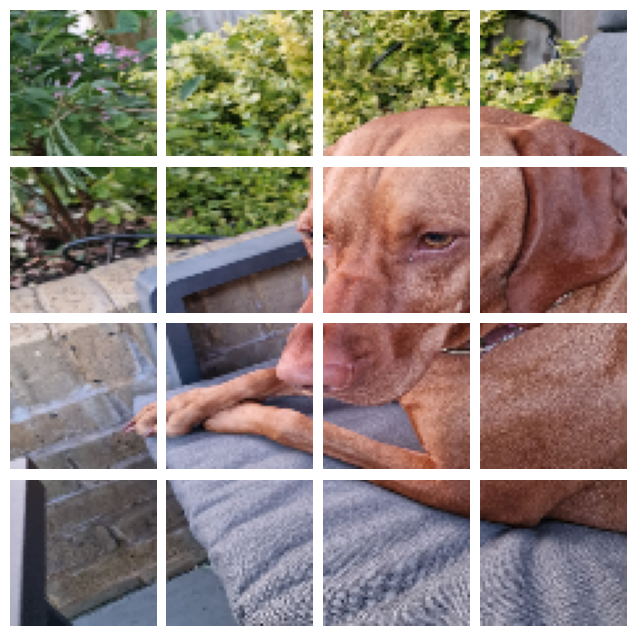

In [12]:
def plot_patches(tensor):
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

    for i, ax in enumerate(grid):
        patch = tensor[i].permute(1, 2, 0).numpy() 
        ax.imshow(patch)
        ax.axis('off')

    plt.show()

plot_patches(p)

#### 1&2. Splitting into patches and embedding in one go

In [ ]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential( ## defines a sequential block of steps to perform on the images
            ## Rearrange is a utility function (usually from the einops library) that rearranges the image tensor into patches.
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            ## Applies a fully connected linear layer
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    ## defines how the module processes input data in a forward pass. The forward pass does not involve learning or weight updates. It's purely for evaluating the current state of the model. In training, the forward pass is followed by a backward pass (backpropagation), where the model calculates the gradient of the loss function with respect to its weights to improve predictions.
    def forward(self, x: Tensor) -> Tensor:
        ## applies self.projection as defined in __init__() above
        x = self.projection(x)
        return x

# Run a quick test
## Extracts the first image from the dataset and adds a batch dimension (unsqueeze)
## NB: dataset[0][0]: Assumes dataset is a PyTorch dataset, where [0][0] retrieves the first image.
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
## Prints the shape of the input image tensor.
print("Initial shape: ", sample_datapoint.shape)
## Instantiates a PatchEmbedding object and applies it to the sample_datapoint. The PatchEmbedding class processes the input image into patch embeddings
embedding = PatchEmbedding()(sample_datapoint)
## Prints the shape of the output tensor.
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


#### Understanding the einops `Rearrange` function.
https://einops.rocks/api/rearrange/ 
- An input tensor has shape [b,c,h,w] where b is batch size (number of images in a batch), c is number of channels (3 for RGB), h is the height of the image, and w is the width of the image.
- The expression inside parentheses (like (h p1) or (w p2)) indicates that a dimension is being split into sub-dimensions or grouped into higher-level dimensions.
- If we want to split an image into patches, the dimensions (h, w) are converted into a grid of patches, each of size p1 x p2.

##### **The input expression `b c (h p1) (w p2)`**
- Keep the batch size unchanged
- Keep the channel size unchanged
- The height is broken into patches of height p1
- The width is broken into patches of width p2

##### **The output expression `b (h w) (p1 p2 c)`**
- Visually, each patch becomes a row, and its features become a single vector. I looks like this:    
```        
Grid of patches:    
[    
Patch_1: [a1, a2, a3, a4, a5, a6],    
Patch_2: [b1, b2, b3, b4, b5, b6],    
...    
]    
```    
- Keep the batch size unchanged
- `(h w)` means group the height and width into a single dimension. The height and width will be flattened (multipled together) to form a single dimension as the output tensor.
    - It means we’re taking the 2D grid structure formed by h rows and w columns and arranging all the elements sequentially in a 1D array.
    - The product h * w represents the total number of elements in the grid.
    - By flattening, you're rearranging these elements in a single, contiguous sequence without changing the order of the elements.
    - E.g going from the following grid:  
        ``` 
        [[a, b, c],    
        [d, e, f]]    
    ```

    To the following array: 
                
    `[a, b, c, d, e, f]`    
        
    - Multiplying h and w is possible because there is no overlap in the data—each element in the 2D grid has a unique position (row and column). Flattening retains the order of these elements while discarding the 2D structure.
- `(p1 p2 c)` means grouping the patch dimensions and the number of channels into one dimension. 
    - Again, this doesn't lose information, only reshape the information.
##### **Why do we perform `b (h w) (p1 p2 c)` and not, say for example, `b (h w p1 p2 c)`?**
- Visually, this would mean all patches and their contents are flattened into one long vector per image i.e. `[a1, a2, ..., z1, z2]`
- `(h w)` represents the full grid of patches that make up an image.
- Flattening these into (p1 p2 c) means each patch is represented as a single feature vector.
- This restructuring allows the data to be processed in a way where:
    - Each row of the reshaped tensor corresponds to a single patch.
    - Each column corresponds to the flattened features of that patch.
- For example, in vision transformers (ViTs), patches are treated as tokens for input to a transformer model, and each patch’s features are represented as a vector.
- Visualising this:
    - `b (h w)` captures the grid of patches.
    - `(p1 p2 c)` captures the internal structure of each patch.
- If we were to use `b (h w p1 p2 c)`, you would flatten all spatial and channel dimensions into a single dimension. This structure would lose the hierarchical distinction between: (a) The grid of patches (h w) and (b) The contents of each patch (p1 p2 c).
- This would make it impossible to:
    - Identify or separate individual patches (since the flattened data mixes patches and their internal structures together).
    - Treat patches as individual units in downstream processing (e.g., in transformers, where each patch is treated as a token).
        


### 3. Normalisation
Layer normalization is a technique used to stabilize and accelerate training by normalizing the activations in the network to have a mean of 0 and variance of 1 across the specified dimension.

In the case of ViTs, dim often corresponds to the number of features of the input (e.g., the hidden size of the transformer).


In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim) ## Layer Normalization layer that normalizes the input tensor x across its features (i.e., across the dim dimension).
        self.fn = fn ## # 'fn' is the function that will be applied after normalization (e.g., attention, feedforward layer)
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs) ## # Apply normalization first, then the function (attention or other)

### 4. Multi-head Attention
We can use Pytorch's MultiheadAttention() module

In [ ]:
## This defines a custom class Attention that inherits from torch.nn.Module
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        '''
        The constructor method initializes the attention mechanism.
        - dim: The dimensions of the input and output of the attention mechanism.
        - n_heads: The number of attention heads in the multi-head attention mechanism.
        - dropout: The dropout probability to apply to the attention weights.
        '''
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [ ]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

##### **What are attention heads?**
An attention head refers to an individual "instance" of the self-attention mechanism. Each attention head performs self-attention on the input data (whether it's a sequence of tokens or image patches). The outputs from multiple attention heads are then combined and passed through further layers in the transformer model.

Instead of using a single attention head, a model will use multiple attention heads (often 8, 12, or more). Each attention head performs _scaled dot-product attention_ (i.e. self-attention) on the input data, but with different learned weight parameters. 

Each attention head focuses on different aspects of the data, for example, one head might focus on local relationships between nearby patches in an image, while another might capture broader global context. 

The outputs from all attention heads are then concatenated and passed through a linear layer to produce the final output.

Example: if you have 8 attention heads, the transformer splits the input (768-dimensional vector) into 8 parts, each part having a lower dimension (e.g., 96 dimensions). Each attention head learns different relationships within the image patches. After performing attention in parallel, the outputs of the 8 heads are concatenated into a vector of size 8 * 96 = 768, which is then processed further.

##### **What is dropout probability?**
The probability with which certain elements (e.g., neurons or activations) are randomly "dropped out" (i.e., set to zero) during training. This technique is used to prevent overfitting and promote generalization in the model by reducing reliance on specific neurons or features.

For instance, if a dropout probability of p = 0.1 is used, it means that, during training, 10% of the units (either activations or weights) will be randomly set to zero in each forward pass, while the remaining 90% will be kept unchanged.

Dropout only occurs during training and not during inference.

##### **What is a multi-head attention layer?**
The "attention mechanism" is a way to get neural networks to understand the most important part of a sentence or image i.e. where the most attention should go. It does this by applying weights to different parts of the image with higher weights where there should be more attention. These weights are learned during training. In NLP, it is also used to predict what the next word in a sentence might be.   

There are different attention mechanisms:
- Dot product (Luong style)
- Additive attention (Bahdanau style)
- Scaled dot product ( a variation on Luong style)

**Query/ key-values**
The attention function maps a set of queries (Q) to a set of key (K) - value (V) pairs. It is a 2D array where each row is a query, so it's just a set of queries. 
-  Query: the element looking for information that best explains itself (i.e., which parts of the input to attend to). This can be a word in a sentence or a patch of an image. 
- Key: each element of the input compared against the query to measure how relevant it is to the query.
- Value: the vector representing the actual content or information for each element _which will turn into_ a score to compare all keys and provide information on which key is most valuable to understanding the query. 

<img src="/Users/hannahjayneknight/Desktop/personal/cv_further_learning/ViT/Q-K_example.png" alt="Q-K example" width="500"/>

**Calculating Attention Scores** 
For each query (one per patch), you calculate a dot product with all keys. This gives you a score indicating how much attention should be paid to each patch.    

For instance, if patch 1's query has a high score with patch 5's key, this means patch 1 is attending to (or "focusing on") patch 5 when determining the output.

<img src="/Users/hannahjayneknight/Desktop/personal/cv_further_learning/ViT/scaled_dot_product_attention.png" alt="Scaled dot product attention" width="500"/>

**Scaled Dot Product Attention**
The function below, _Attention(Q, K, V)_, shows how to calculate the "attention score". 
1. First, we apply the dot product between Q and K, which tells us the similarity between the vectors, i.e. for each query which key it is most similar to. 
2. We then scale this score by dividing by the square route of d_k (the dimension of the keys). As explained in the "Attention is all you need", this is to ensure that for large values of d_k, the softmax function is not pushed to regions where it has extremely small gradients.
3. Then we apply a softmax function to ensure the score is between 0 and 1. Now they are weights called _attention weights_.
4. Then we multiply the attention weights by the values to... (?)

Note: when all values for Q, K and V are the same, this is called self attention!

### 5. Feedforward
This defines a two-layer MLP with activation functions and dropout between layers.

The feedforward layer plays a crucial role in enabling the model to capture complex, nonlinear relationships in the data after the self-attention mechanism.

While self-attention helps the model capture global and local relationships, it cannot introduce complex nonlinear patterns on its own.

The feedforward layer introduces nonlinearity through activation functions like GELU (or ReLU in some variants). This helps the model learn more complex, expressive features and relationships that can't be captured by linear operations alone.

In [ ]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__(
            ## eg input shape is (1, 5, 128)
            nn.Linear(dim, hidden_dim),      # First Linear layer (input size: dim, output size: hidden_dim), input transformed to (1, 5, 256)
            nn.GELU(),                       # GELU activation function, shape remains (1, 5, 256)
            nn.Dropout(dropout),             # Dropout layer after activation, shape remains (1, 5, 256)
            nn.Linear(hidden_dim, dim),      # Second Linear layer (input size: hidden_dim, output size: dim), shape now (1, 5, 128)
            nn.Dropout(dropout)              # Dropout layer after the second Linear layer, output shape (1, 5, 128)
        )

ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

### Residual connections
_Residual connections_ adds the input to the attention output, preserving useful information from earlier layers. They ensure that each sub-layer outputs a refined version of the input, rather than entirely replacing it.

Without residual connections, the gradients could either vanish or explode as they are propagated back through many layers, especially in very deep networks. Adding the input (x) back into the output of the layer helps maintain a stable gradient flow.

They allow the model to learn identity mappings more effectively, meaning the model can skip unnecessary transformations if they don't help improve performance.

The residual connection ensures that the original features (the ones before the transformation) are not lost and can still influence the final output.

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

### PUTTING IT ALL TOGETHER

In [ ]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))


### TRAINING

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [ ]:
import torch.optim as optim
import numpy as np

device = "cuda"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1000):
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    if epoch % 5 == 0:
        print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
        epoch_losses = []
        # Something was strange when using this?
        # model.eval()
        for step, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())
        print(f">>> Epoch {epoch} test loss: ", np.mean(epoch_losses))

In [ ]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)

print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)